# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [77]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [78]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataset import get_df_action, get_features_ts, get_train_test_data, label_collision_data, predict_anomaly_score
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve, plot_all_anomalies_over_time
from metrics import Confidence, anomaly_detection_metric, compute_metrics, compute_various_thresholds

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [79]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [80]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)

xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
collisions_adjusted_rec_1 = collision_rec1.Timestamp - pd.to_timedelta([2] * len(collision_rec1.Timestamp), 'h')
collisions_adjusted_rec_5 = collision_rec5.Timestamp - pd.to_timedelta([2] * len(collision_rec5.Timestamp), 'h')

# transform in like collision
collisions['Timestamp'] = collisions_adjusted
collision_rec1['Timestamp'] = collisions_adjusted_rec_1
collision_rec5['Timestamp'] = collisions_adjusted_rec_5

# COLLISION DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec1_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_1, df_collision_1, df_meta_collision_1, action2int_collision_1 = get_df_action(filepath_csv, filepath_meta)

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.csv")]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec5_collision_20220811_rbtc_{freq}s.metadata")]
df_action_collision_5, df_collision_5, df_meta_collision_5, action2int_collision_5 = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [81]:
# plot_signals(df, df_action, "Normal signals", saveplot=False)
# plot_signals(df_collision, df_action_collision, "Collision signals", saveplot=False)
# plot_signals(df_collision_1, df_action_collision_1, "Collision signals 1", saveplot=False)
# plot_signals(df_collision_5, df_action_collision_5, "Collision signals 5", saveplot=False)

### Features Exctraction

In [82]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
df_features_collision_1 = get_features_ts("statistical", df_action_collision_1, df_meta_collision_1, frequency, action2int_collision_1)
df_features_collision_5 = get_features_ts("statistical", df_action_collision_5, df_meta_collision_5, frequency, action2int_collision_5)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
Computing features.


Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 154.7367389202118 seconds ---


In [83]:
X_train, y_train, X_test, y_test = get_train_test_data(df_features, df_features_collision, full_normal=True)
X_train1, y_train1, X_test1, y_test1 = get_train_test_data(df_features, df_features_collision_1, full_normal=True)
X_train5, y_train5, X_test5, y_test5 = get_train_test_data(df_features, df_features_collision_5, full_normal=True)

In [84]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)
df_with_labels_1 = label_collision_data(df_features_collision_1, collisions_adjusted_rec_1)
df_with_labels_5 = label_collision_data(df_features_collision_5, collisions_adjusted_rec_5)

In [85]:
y_collision = df_with_labels['is_collision']
y_collision_1 = df_with_labels_1['is_collision']
y_collision_5 = df_with_labels_5['is_collision']


## LSTM-ED

In [86]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=100,
    batch_size=64,
    lr=1e-4,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.25,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


100%|██████████| 100/100 [03:01<00:00,  1.81s/it]


LSTM-ED training completed.


In [87]:
anomaly_scores = predict_anomaly_score(X_test, classifier)
anomaly_scores1 = predict_anomaly_score(X_test1, classifier)
anomaly_scores5 = predict_anomaly_score(X_test5, classifier)

Anomaly prediction completed.
Anomaly prediction completed.
Anomaly prediction completed.


In [88]:
thresholds = compute_various_thresholds(anomaly_scores)
thresholds_1 = compute_various_thresholds(anomaly_scores1)
thresholds_5 = compute_various_thresholds(anomaly_scores5)

Number of anomalies detected: 10 with threshold 1097.621823775651, std
Number of anomalies detected: 126 with threshold 127.36803176551962, mad
Number of anomalies detected: 16 with threshold 1044.016528538937, percentile
Number of anomalies detected: 4 with threshold 1549.7001543587571, IQR

Number of anomalies detected: 10 with threshold 803.2307647357245, std
Number of anomalies detected: 51 with threshold 94.27385077020129, mad
Number of anomalies detected: 9 with threshold 980.4431724000284, percentile
Number of anomalies detected: 18 with threshold 314.64287399641546, IQR

Number of anomalies detected: 2 with threshold 1334.3558545671337, std
Number of anomalies detected: 2 with threshold 1499.025429087791, mad
Number of anomalies detected: 8 with threshold 1075.4793559938475, percentile
Number of anomalies detected: 1 with threshold 1900.2704341139006, IQR



### Anomaly Detection

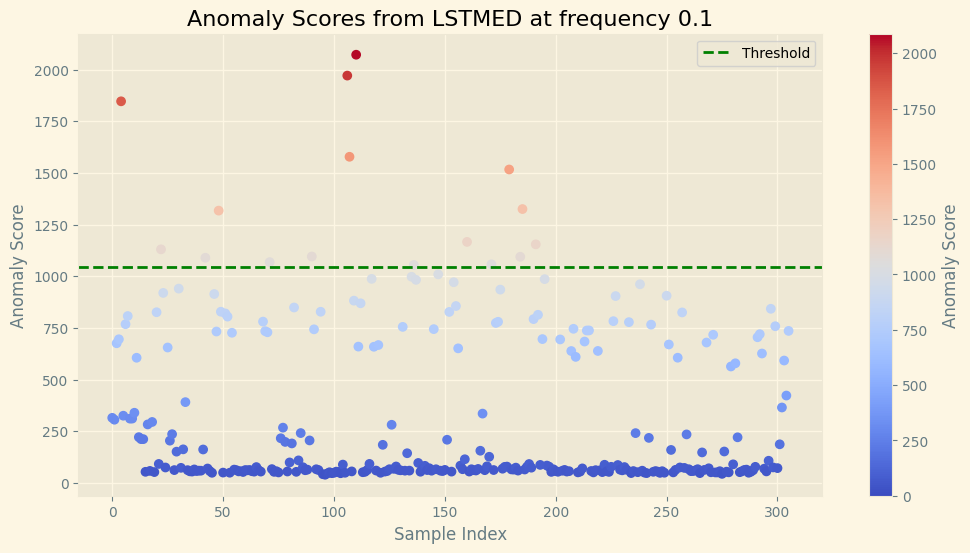

Number of anomalies detected: 16


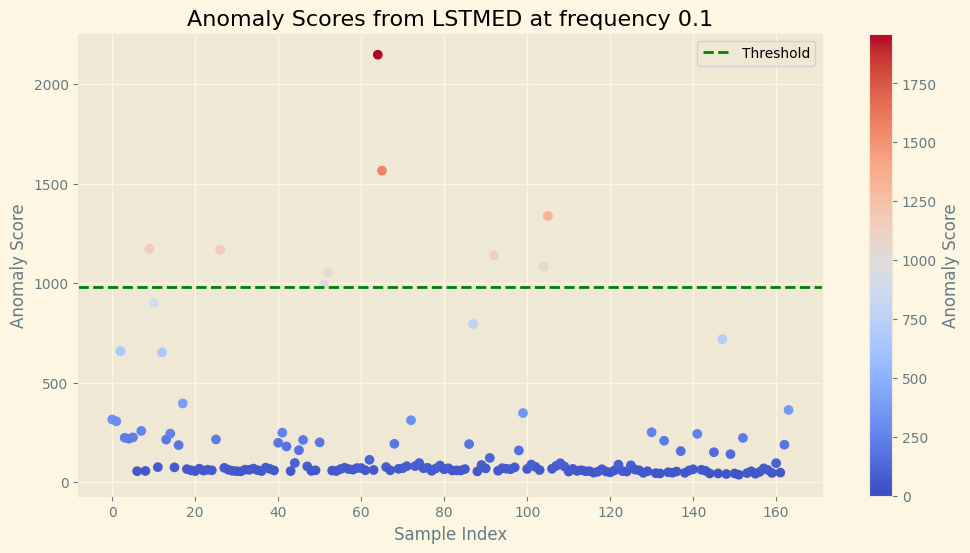

Number of anomalies detected: 9


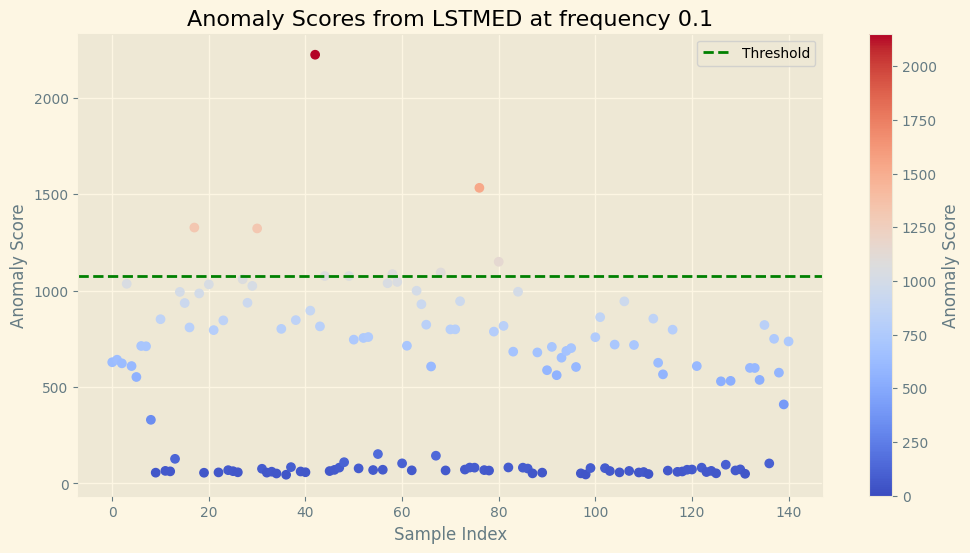

Number of anomalies detected: 7


In [89]:
anomalies_detected = plot_anomalies(anomaly_scores, freq, thresholds[2])
anomalies_detected1 = plot_anomalies(anomaly_scores1, freq, thresholds_1[2])
anomalies_detected5 = plot_anomalies(anomaly_scores5, freq, thresholds_5[2])

In [90]:
np.count_nonzero(y_collision), np.count_nonzero(y_collision_1), np.count_nonzero(y_collision_5)

(105, 35, 56)

In [91]:
compute_metrics(anomaly_scores, y_collision, thresholds[2])
print("############################################")
compute_metrics(anomaly_scores1, y_collision_1, thresholds_1[2])
print("############################################")
compute_metrics(anomaly_scores5, y_collision_5, thresholds_5[2])

ROC AUC Score: 0.9747
Detected anomaly class: 1
Threshold: 1044.0165
F1 Score: 0.2479
Accuracy: 0.7026
Precision: 0.9375
Recall: 0.1429
              precision    recall  f1-score   support

           0       0.69      1.00      0.81       201
           1       0.94      0.14      0.25       105

    accuracy                           0.70       306
   macro avg       0.81      0.57      0.53       306
weighted avg       0.77      0.70      0.62       306

############################################
ROC AUC Score: 0.9743
Detected anomaly class: 1
Threshold: 980.4432
F1 Score: 0.4091
Accuracy: 0.8415
Precision: 1.0000
Recall: 0.2571
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       129
           1       1.00      0.26      0.41        35

    accuracy                           0.84       164
   macro avg       0.92      0.63      0.66       164
weighted avg       0.87      0.84      0.80       164

##############################

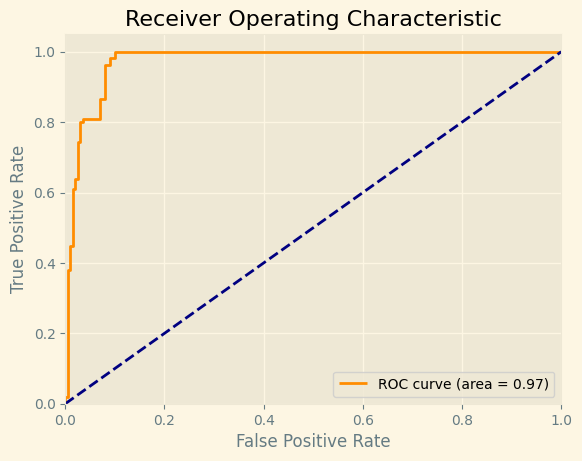

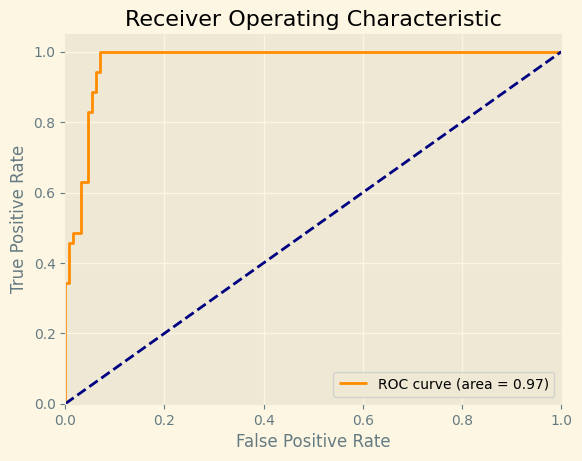

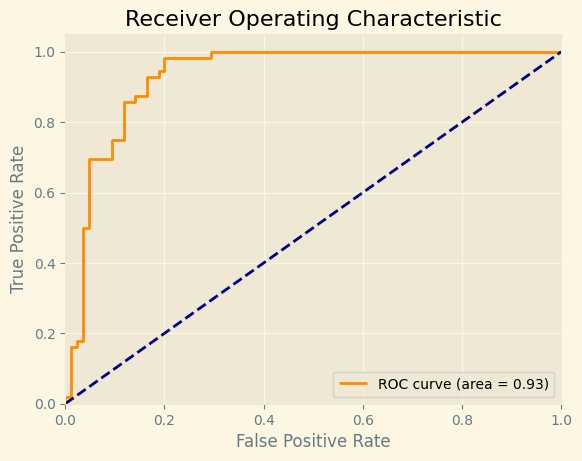

In [92]:
plot_roc_curve(y_collision, anomaly_scores)
plot_roc_curve(y_collision_1, anomaly_scores1)
plot_roc_curve(y_collision_5, anomaly_scores5)

## Map anomalies to original time series

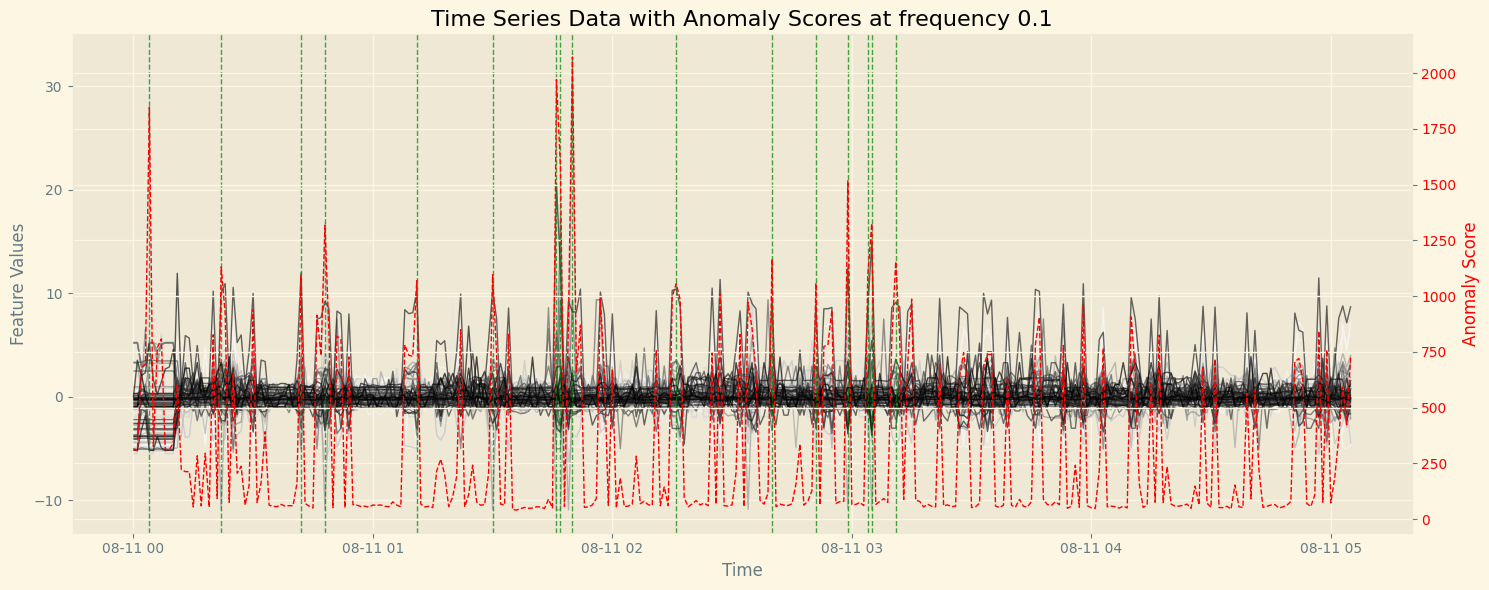

Top 16 Anomalies:
              timestamp  anomaly_score  \
110 2022-08-11 01:50:00    2072.475020   
106 2022-08-11 01:46:00    1971.532959   
4   2022-08-11 00:04:00    1847.051120   
107 2022-08-11 01:47:00    1578.646968   
179 2022-08-11 02:59:00    1517.137259   
185 2022-08-11 03:05:00    1325.725171   
48  2022-08-11 00:48:00    1318.147055   
160 2022-08-11 02:40:00    1166.750379   
191 2022-08-11 03:11:00    1154.965236   
22  2022-08-11 00:22:00    1130.765095   
90  2022-08-11 01:30:00    1096.135848   
184 2022-08-11 03:04:00    1094.769358   
42  2022-08-11 00:42:00    1089.932363   
71  2022-08-11 01:11:00    1068.905221   
171 2022-08-11 02:51:00    1058.352702   
136 2022-08-11 02:16:00    1055.453472   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
106                                          -1.885449      
4                                            -5.323114      
107                    

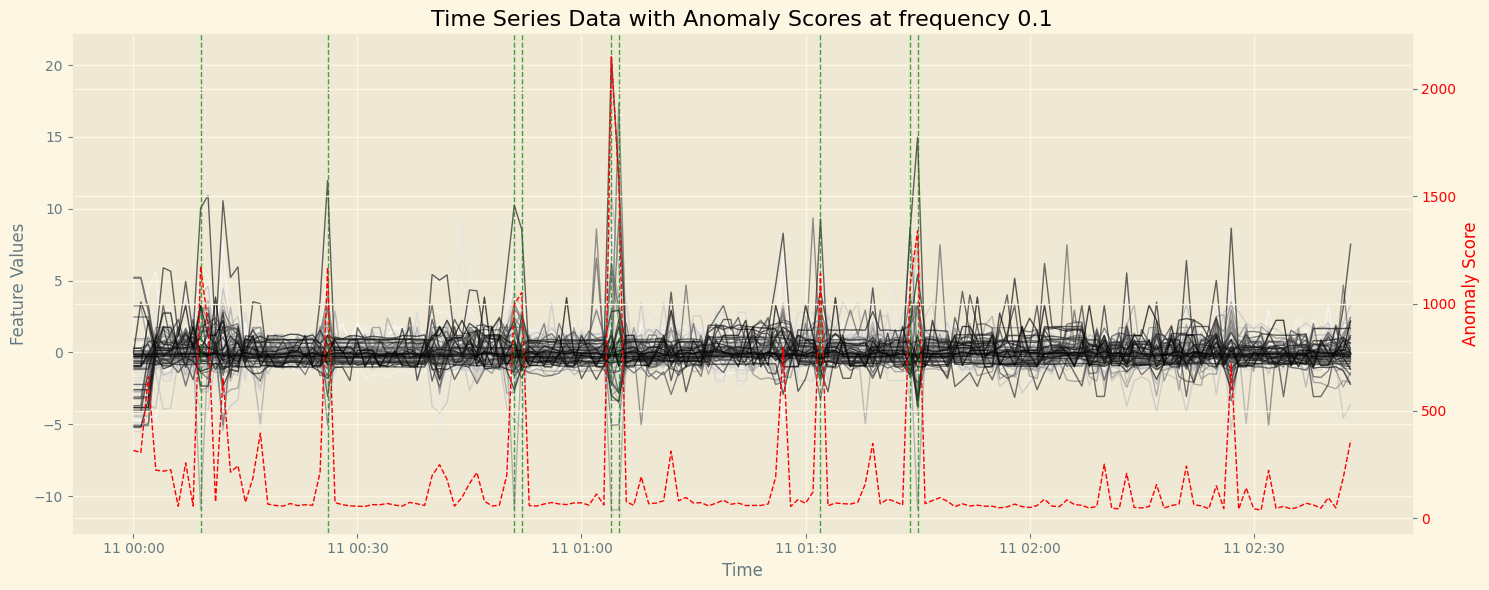

Top 9 Anomalies:
              timestamp  anomaly_score  \
64  2022-08-11 01:04:00    2148.260206   
65  2022-08-11 01:05:00    1566.047746   
105 2022-08-11 01:45:00    1338.315315   
9   2022-08-11 00:09:00    1173.959058   
26  2022-08-11 00:26:00    1168.466081   
92  2022-08-11 01:32:00    1140.129966   
104 2022-08-11 01:44:00    1082.875209   
52  2022-08-11 00:52:00    1051.675407   
51  2022-08-11 00:51:00     994.411178   

     machine_nameKuka Robot_apparent_power-_Average power  \
64                                           -1.885449      
65                                           -1.181816      
105                                          -1.065886      
9                                            -0.820232      
26                                           -1.678108      
92                                           -0.426667      
104                                          -1.514041      
52                                           -1.023372      
51           

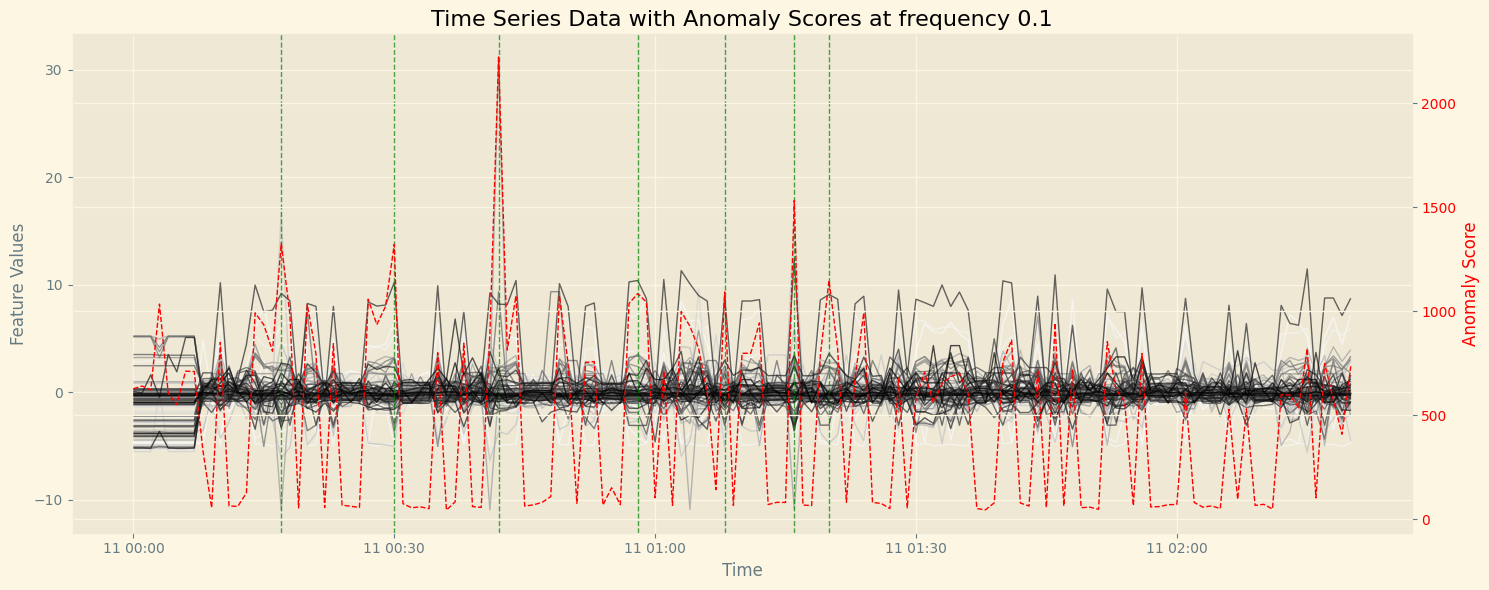

Top 7 Anomalies:
             timestamp  anomaly_score  \
42 2022-08-11 00:42:00    2223.030147   
76 2022-08-11 01:16:00    1532.854901   
17 2022-08-11 00:17:00    1326.788284   
30 2022-08-11 00:30:00    1322.293496   
80 2022-08-11 01:20:00    1149.457097   
68 2022-08-11 01:08:00    1093.737000   
58 2022-08-11 00:58:00    1085.429667   

    machine_nameKuka Robot_apparent_power-_Average power  \
42                                          -0.911260      
76                                          -1.338344      
17                                          -0.707436      
30                                          -1.305574      
80                                          -1.083291      
68                                          -1.319110      
58                                          -1.354701      

    machine_nameKuka Robot_apparent_power-_Variance  \
42                                         0.246879   
76                                         0.201584   
17      

In [93]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)
plot_anomalies_over_time(X_test1, anomaly_scores1, anomalies_detected1, freq)
plot_anomalies_over_time(X_test5, anomaly_scores5, anomalies_detected5, freq)